In [181]:
# %reset -f
# %config InlineBackend.figure_format = 'retina'
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
import os
import datetime
# import dill as pickle

In [182]:
data = pd.read_csv('bikeshare/bike-sharing-demand/train.csv')
data['datetime'] = pd.to_datetime(data['datetime'])

# 删除节日，
data = data[data['holiday'] == 0]
# correlation
data['hour'] = data['datetime'].dt.hour
data['hour'] = data['datetime'].dt.hour
data.sort_values('datetime',inplace=True)
data['day_of_week'] = data['datetime'].dt.dayofweek

In [183]:
# 删除周末
data = data[(data['day_of_week'] != 5) & (data['day_of_week'] != 6)] # 0 is monday

data['date'] = data['datetime'].dt.date
all_date = np.unique(data['date'].values)
data['day_id'] = data['date'].apply(lambda x: np.where(all_date == x)[0][0])
data['week_id'] = data['datetime'].dt.isocalendar().week + 51 * (data['datetime'].dt.year == 2012) - 1


In [184]:
class OneDay():
    def __init__(self, day, day_of_week, whether_train):
        self.day = day
        self.count_each_hour = np.zeros(24,dtype=int)
        self.covariate_each_hour = np.ones(24,dtype=object)
        self.day_of_week = day_of_week
        self.no_data = True
        self.season = None
        self.atemp_each_hour = np.zeros(24)
        self.humidity_each_hour = np.zeros(24)
        self.windspeed_each_hour = np.zeros(24)
        self.temp_each_hour = np.zeros(24)
        self.weather_each_hour = np.zeros(24)
        self.get_data = np.zeros(24)

    def add_one_hour(self, hour, count: int, covariate, season, weather, atemp, humidity, windspeed, temp):
        self.count_each_hour[hour] = count
        self.covariate_each_hour[hour] = covariate
        self.no_data = False
        self.season = season
        self.atemp_each_hour[hour] = atemp
        self.humidity_each_hour[hour] = humidity
        self.windspeed_each_hour[hour] = windspeed
        self.temp_each_hour[hour] = temp
        self.weather_each_hour[hour] = weather
        self.get_data[hour] = 1

    def get_summary(self):
        self.median_temp = np.median(self.temp_each_hour)
        self.weather = np.max(self.weather_each_hour)
        if self.weather == 4:
            self.weather = 3
        self.total_count = np.sum(self.count_each_hour)
        
    def get_training_data(self):
        # return np.concatenate([[self.median_temp], [self.weather], self.count_each_hour])
        return self.count_each_hour
        
class AllDays():
    def __init__(self):
        self.n_days = 0
        self.days_ls = np.array([])
        self.day_id_ls = np.array([])
        self.date_ls = np.array([])
        
    def add_one_hour(self, day, hour, count, covariate, season, weather, day_of_week, atemp, humidity, windspeed, temp):
        if day in self.day_id_ls:
            self.days_ls[np.where(np.array(self.day_id_ls)==day)[0][0]].add_one_hour(hour=hour, count=count, covariate=covariate, season=season, weather=weather, atemp=atemp, humidity=humidity, windspeed=windspeed, temp=temp)
        else:
            new_day = OneDay(day=day, day_of_week=day_of_week, whether_train=True)
            self.days_ls = np.append(self.days_ls, new_day)
            self.day_id_ls = np.append(self.day_id_ls, day)
            self.days_ls[-1].add_one_hour(hour=hour, count=count, covariate=covariate, season=season, weather=weather, atemp=atemp, humidity=humidity, windspeed=windspeed, temp=temp)
            self.n_days += 1
            self.date_ls = np.append(self.date_ls, day)
        
    def sort_days(self):
        self.days_ls = self.days_ls[np.argsort(self.date_ls)]
        self.day_id_ls = self.day_id_ls[np.argsort(self.date_ls)]
        self.date_ls = self.date_ls[np.argsort(self.date_ls)]

    def get_count_mat_with_data(self, whether_train, day_of_week=None, season=None, weather=None):
        # return a matrix, each row is one day, each column is one hour, only consider days with data
        # if day_of_week is given, then return the data in that day of week
        # else return data in all days with count recording
        whether_return = np.array([True] * self.n_days)
        if season:
            whether_return[[one_day.season != season for one_day in self.days_ls]] = False
        if day_of_week:
            whether_return[[one_day.day_of_week != day_of_week for one_day in self.days_ls]] = False
        if weather:
            whether_return[[one_day.weather != weather for one_day in self.days_ls]] = False
        return np.array([one_day.count_each_hour for one_day in self.days_ls[whether_return]])
              
    def get_summary(self):
        for one_day in self.days_ls:
#             assert one_day.full_data
            one_day.get_summary()
    
    def get_covariate_df(self):
        total_count_ls = [one_day.total_count for one_day in self.days_ls]
        weather_ls =[one_day.weather for one_day in self.days_ls]
        median_temp_ls =[one_day.median_temp for one_day in self.days_ls]
        dt = pd.DataFrame(list(zip(total_count_ls,weather_ls,median_temp_ls)),columns=['total_count','weather','median_temp'],index=self.date_ls)
#         dt.sort_values(by=['weather','median_temp'], inplace=True)
        return dt

    def keep_date(self, start_date, end_date):
        whether_keep = [one_day.day <= end_date and one_day.day >= start_date for one_day in self.days_ls]
        return_all_day = AllDays()
        return_all_day.days_ls = self.days_ls[whether_keep]
        return_all_day.day_id_ls = self.day_id_ls[whether_keep]
        return_all_day.date_ls = self.date_ls[whether_keep]
        return_all_day.n_days = sum(whether_keep)
        return return_all_day
    
    def get_training_set(self):
        training_set = []
        for one_day in all_days.days_ls:
            training_set.append(one_day.get_training_data())
        training_set = np.array(training_set)
        return training_set

In [185]:
all_days = AllDays()
for i in range(len(data)):
    one_day_dt = data.iloc[i]
    all_days.add_one_hour(day=one_day_dt['date'],
                          hour=one_day_dt['hour'],
                          count=one_day_dt['count'],
                          covariate=1,
                          season=one_day_dt.season,
                          weather=one_day_dt.weather,
                          day_of_week=one_day_dt.day_of_week,
                          atemp=one_day_dt.atemp,
                          humidity=one_day_dt.humidity,
                          windspeed=one_day_dt.windspeed,
                          temp=one_day_dt.temp)

all_days.sort_days()
all_days.get_summary()
# season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
# weather - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
#           2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
#           3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
#           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

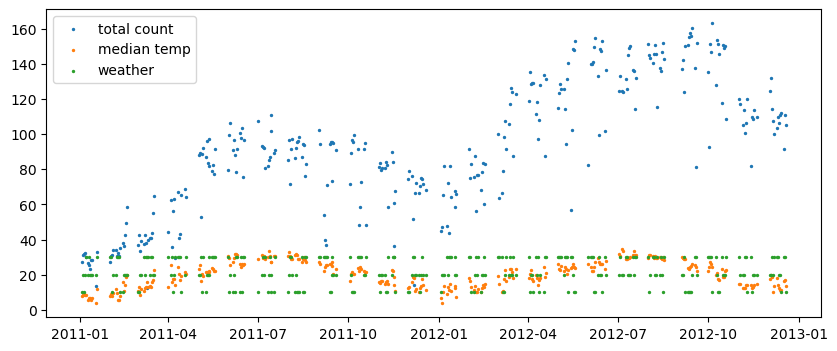

In [187]:
plt.figure(figsize=(10,4))
df = all_days.get_covariate_df()
df.sort_values(by=['weather','median_temp'], inplace=True)

plt.scatter(df.index, df.total_count/50,s=2,label='total count')
plt.scatter(df.index, df.median_temp,s=2,label='median temp')
plt.scatter(df.index, df.weather*10,s=2,label='weather')
plt.legend()

In [192]:
np.sort(df.index)

array([datetime.date(2011, 1, 3), datetime.date(2011, 1, 4),
       datetime.date(2011, 1, 5), datetime.date(2011, 1, 6),
       datetime.date(2011, 1, 7), datetime.date(2011, 1, 10),
       datetime.date(2011, 1, 11), datetime.date(2011, 1, 12),
       datetime.date(2011, 1, 13), datetime.date(2011, 1, 14),
       datetime.date(2011, 1, 18), datetime.date(2011, 1, 19),
       datetime.date(2011, 2, 1), datetime.date(2011, 2, 2),
       datetime.date(2011, 2, 3), datetime.date(2011, 2, 4),
       datetime.date(2011, 2, 7), datetime.date(2011, 2, 8),
       datetime.date(2011, 2, 9), datetime.date(2011, 2, 10),
       datetime.date(2011, 2, 11), datetime.date(2011, 2, 14),
       datetime.date(2011, 2, 15), datetime.date(2011, 2, 16),
       datetime.date(2011, 2, 17), datetime.date(2011, 2, 18),
       datetime.date(2011, 3, 1), datetime.date(2011, 3, 2),
       datetime.date(2011, 3, 3), datetime.date(2011, 3, 4),
       datetime.date(2011, 3, 7), datetime.date(2011, 3, 8),
       dat

In [190]:
training_set = all_days.get_training_set()
np.save('bikeshare/training_set.npy', training_set)